Analyze trip files converted from OMX matrices
1. Are trips sorted by departure time?
2. How does the temporal distribution look?
3. What are the distribution by mode, purpose, VoT?

In [7]:
import numpy as np
import pandas as pd
import h5py
import os
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Summarize OMX Trip Tables

In [8]:
# matrix_folder = r'C:\Projects\SWIFT\SWIFT_Workspace\Scenarios\Scenario_S4_Full\STM\STM_D\Outputs_SWIFT'
matrix_folder = r'C:\Projects\SWIFT\SWIFT_Workspace\Scenarios\Scenario_S12\STM\STM_D'
matrices_am = ["OD AM3HR Vehicles4DynusT EV", "OD AM3HR Vehicles4DynusT NonEV"]
matrices_md = ["OD MD6HR Vehicles4DynusT EV", "OD MD6HR Vehicles4DynusT NonEV"]
matrices_pm = ["OD PM4HR Vehicles4DynusT EV", "OD PM4HR Vehicles4DynusT NonEV"]
matrices_ov = ["OD OV8HR Vehicles4DynusT EV", "OD OV8HR Vehicles4DynusT NonEV"]
matrices = matrices_am + matrices_md + matrices_pm + matrices_ov
matrix_files = [os.path.join(matrix_folder, m+'.omx') for m in matrices]

In [9]:
vots = {
        "wi1da": 9.6, "wi2da": 15.04, "wi3da": 20.48, "wi4da": 27.52, "wi5da": 37.12,
        "wi12a2": 21.56, "wi3a2": 35.84, "wi45a2": 56.56,
        "wi12a3": 30.8, "wi3a3": 51.2, "wi45a3": 80.8,
        "nwi12da": 7.03, "nwi3da": 13.44, "nwi45da": 23.65,
        "nwi12a2": 12.3, "nwi3a2": 23.52, "nwi45a2": 41.39,
        "nwi12a3": 17.57, "nwi3a3": 33.6, "nwi45a3": 59.12,
        "Cargo": 64.0, "Serv": 40.0, "taxi_exta": 18.94, "TNC": 18.94
    }

map_purp = {
    1: "WK", 
    2: "NW", 
    3: "Taxi",
    4: "TNC",
    5: "Service",
    6: "Cargo",
    
    10: "WK", 
    20: "NW", 
    30: "Taxi",
    40: "TNC",
    50: "Service",
    60: "Cargo"
    
}


In [10]:
def parse_matrix_table(matrix_file_name, matrix_name, vots):
    """
    Parse the matrix name "amnhoai45" for vehicle type, value of time, period, and purpose
    :param matrix_name:
    :type str
    :param vots:        a dict for vots
    :return: a tuple, vehicle_type, occupancy, purpose, value_of_time, period
    """

    matrix_name = matrix_name.lower()

    vtype = occ = purp = vot = 0
    time_period = (0, 0)
    period = ''

    cav, ev = False, False

    if matrix_name.lower().find("da") >= 0:
        if matrix_name.lower().find("cav") >= 0:
            vtype = 5
            occ = 0
            cav = True
        elif matrix_name.lower().find("reg") >= 0:
            vtype = 1
            occ = 0
            cav = False

    elif matrix_name.lower().find("s2") >= 0 or matrix_name.find("a2") >= 0:
        if matrix_name.lower().find("cav") >= 0:
            vtype = 6
            occ = 1
            cav = True
        elif matrix_name.lower().find("reg") >= 0:
            vtype = 2
            occ = 1
            cav = False
    elif matrix_name.lower().find("s3") >= 0 or matrix_name.find("a3") >= 0:
        if matrix_name.lower().find("cav") >= 0:
            vtype = 6
            occ = 1
            cav = True
        elif matrix_name.lower().find("reg") >= 0:
            vtype = 2
            occ = 1
            cav = False
    elif matrix_name.lower().find("cargo") >= 0:
        if matrix_name.lower().find("cav") >= 0:
            vtype = 8
            occ = 2
            cav = True
        else:
            vtype = 4
            occ = 2
            cav = False
    elif matrix_name.lower().find("serv") >= 0:
        if matrix_name.lower().find("cav") >= 0:
            vtype = 7
            occ = 2
            cav = True
        else:
            vtype = 3
            occ = 2
            cav = False
    elif matrix_name.lower().find("taxi") >= 0:
        vtype = 2
        occ = 1
    elif matrix_name.lower().find("exta") >= 0:
        vtype = 2
        occ = 0
    elif matrix_name.lower().find("tnc") >= 0:
        vtype = 9
        occ = 1

    if matrix_name.find("_w") >= 0:
        if matrix_file_name.lower().find("dynust nonev") >= 0:
            purp = 1
        else:
            purp = 10
            ev = True
    elif matrix_name.find("_nw") >= 0:
        if matrix_file_name.lower().find("dynust nonev") >= 0:
            purp = 2
        else:
            purp = 20
            ev = True
    elif matrix_name.lower().find("taxi") >= 0:
        if matrix_file_name.lower().find("dynust nonev") >= 0:
            purp = 3
        else:
            purp = 30
            ev = True
    elif matrix_name.lower().find("tnc") >= 0:
        if matrix_file_name.lower().find("dynust nonev") >= 0:
            purp = 4
        else:
            purp = 40
            ev = True
    elif matrix_name.lower().find("serv") >= 0:
        if matrix_file_name.lower().find("dynust nonev") >= 0:
            purp = 5
        else:
            purp = 50
            ev = True
    elif matrix_name.lower().find("cargo") >= 0:
        if matrix_file_name.lower().find("dynust nonev") >= 0:
            purp = 6
        else:
            purp = 60
            ev = True

    # Time periods
    if matrix_file_name.lower().find("am") >= 0:
        period = 'am'
        time_period = '6..9'
    elif matrix_file_name.lower().find("md") >= 0:
        period = 'md'
        time_period = '9..15'
    elif matrix_file_name.lower().find("pm") >= 0:
        period = 'pm'
        time_period = '15..19'
    else:
        period = 'ov'
        time_period = '0..6, 19..24'

    for key in vots.keys():
        if matrix_name.find(key) >= 0:
            vot = vots[key]
            break

    return dict(vtype=vtype, occ=occ, purp=purp, vot=vot, time_period=time_period, period=period, cav=cav, ev=ev)

In [11]:
def summarize_trip_tables(matrix_files, vots):
    summary_records = []
    for m in matrix_files:
#         print('Processing Matrix File {:s}'.format(m))
        h5 = h5py.File(m, 'r')
        tables = h5['/data/'].keys()
        for table in tqdm(tables, desc=os.path.split(m)[1].split('.')[0]):
            if table.find('all') >= 0:
                continue
            info = parse_matrix_table(m, table, vots)
            vtype = info['vtype']
            occ = info['occ']
            purp = info['purp']
            vot = info['vot']
            period = info['period']
            cav = info['cav']
            ev = info['ev']
            
            if cav:
                cav = 'CAV'
            else:
                cav = 'REG'
            
            if ev:
                ev = 'EV'
            else:
                ev = 'NonEV'
            
            od = h5['/data/' + table][:]
            trips = od.sum()
            summary_records.append((table.lower(), period, purp, vot, vtype, occ, cav, ev, trips))
    
    return pd.DataFrame(data=summary_records, columns=['table', 'period', 'purp', 'vot', 'vtype', 'occ', 'cav', 'ev', 'trips'])
    

In [12]:
summary_omx = summarize_trip_tables(matrix_files, vots)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [13]:
summary_omx['purp'] = summary_omx.purp.map(map_purp)

In [14]:
summary_omx_gb = summary_omx.groupby(['period', 'purp', 'vtype', 'occ', 'cav', 'ev'], as_index=False)['trips'].sum()
summary_omx_gb.head()

,period,purp,vtype,occ,cav,ev,trips
0,am,Cargo,4,2,REG,EV,3894.141
1,am,Cargo,4,2,REG,NonEV,24339.711
2,am,NW,1,0,REG,EV,144982.867
3,am,NW,1,0,REG,NonEV,49629.123
4,am,NW,2,1,REG,EV,45616.976


#### Facet View

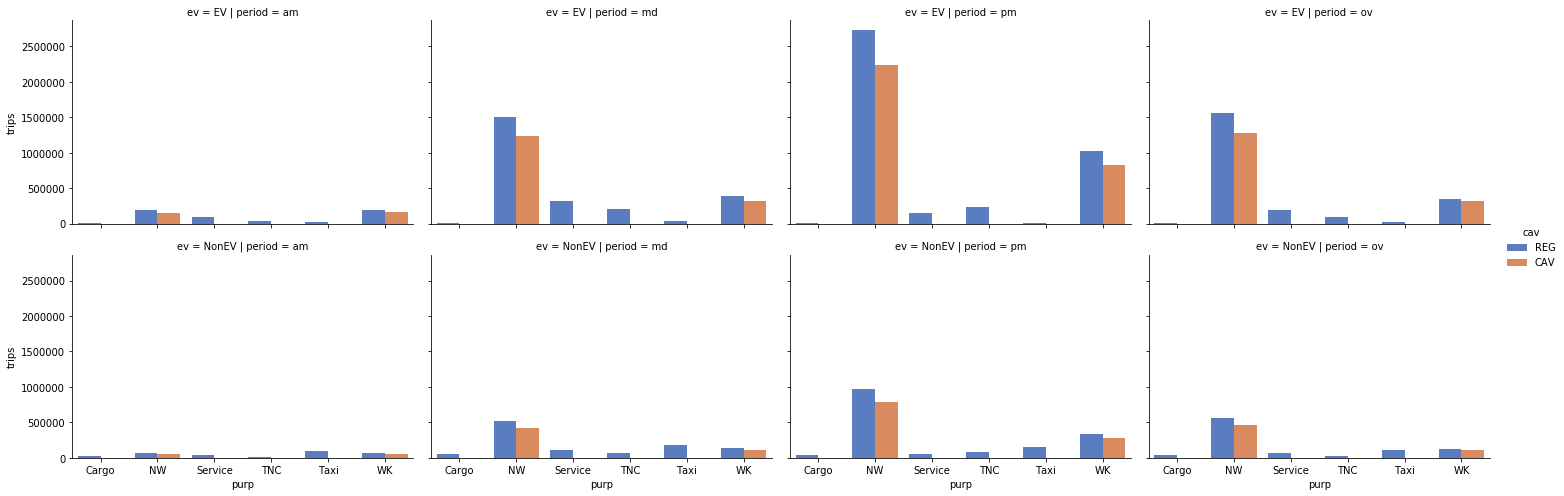

In [15]:
summary_omx_gb_plot = summary_omx_gb.groupby(['period', 'purp', 'cav', 'ev'], as_index=False)['trips'].sum()
g = sns.catplot(x="purp", y="trips", hue="cav", row='ev', col="period", kind='bar', col_order=['am','md','pm','ov'], 
                data=summary_omx_gb_plot, height=3.5, aspect=1.5, order=summary_omx_gb_plot.purp.unique(), 
           palette=sns.color_palette("muted", n_colors=2), hue_order=summary_omx_gb_plot.cav.unique(), ci=None)

#### Period Totals

In [65]:
summary_omx_gb_period_totals = summary_omx_gb.groupby('period', as_index=False)['trips'].sum()
summary_omx_gb_period_totals['SHARE'] = summary_omx_gb_period_totals['trips'] / sum(summary_omx_gb_period_totals['trips'])
summary_omx_gb_period_totals

,period,trips,SHARE
0,am,1277437.417,0.058
1,md,5625972.107,0.254
2,ov,5336136.315,0.241
3,pm,9889880.250,0.447


### Summary Converted Trip File

In [20]:
flat_trip_file = r'C:\Projects\SWIFT\SWIFT_Workspace\Scenarios\Scenario_S12\STM\STM_A\01_DynusT\02_Demand\vehicle.csv'

In [21]:
df_flat_trip = pd.read_csv(flat_trip_file)
df_flat_trip.head()

,vid,usec,dsec,stime,vehcls,vehtype,ioc,#ONode,#IntDe,info,...,Izone,Evac,InitPos,VoT,tFlag,pArrTime,TP,IniGas,DZone,waitTime
0,1,44598,59076,0.000,3,5,0,1,1,0,...,380,0,0.300,37.120,0,0.000,10,0.000,2020,0.000
1,2,46318,282965,0.000,3,5,0,1,1,0,...,1861,0,0.919,37.120,0,0.000,10,0.000,423,0.000
2,3,341141,333619,0.000,3,5,0,1,1,0,...,2788,0,0.288,37.120,0,0.000,10,0.000,2937,0.000
3,4,23384,302871,0.000,3,5,0,1,1,0,...,909,0,0.551,9.600,0,0.000,10,0.000,2324,0.000
4,5,286624,20298,0.000,3,6,1,1,1,0,...,1494,0,0.724,80.800,0,0.000,10,0.000,2317,0.000


#### Occupancy Distribution

In [22]:
df_flat_trip.ioc.value_counts()

0    15343644
1     5592221
2     1214479
Name: ioc, dtype: int64

#### Vehicle type distribution

In [23]:
df_flat_trip.vehtype.value_counts().sort_index()

1    8424037
2    2942697
3    1029356
4     185123
5    6919607
6    1901298
9     748226
Name: vehtype, dtype: int64

#### Purpose distribution

In [24]:
df_flat_trip.TP.value_counts().sort_index()

1      1225702
2      3835242
3       530668
4       184893
5       259093
6       155238
10     3625110
20    10892955
30       77962
40      563333
50      770263
60       29885
Name: TP, dtype: int64

#### Are trips sorted by departure time in non-decreasing order?

In [25]:
print('Trips are sorted by stime in increasing order = {:s}'.format(str(df_flat_trip.stime.is_monotonic_increasing)))

Trips are sorted by stime in increasing order = True


#### Compare temporal distribution

In [43]:
INPUT_DIURNAL_FILE = r'C:\Projects\SWIFT\SWIFT_Workspace\CommonData\STM\STM_A\Shared_Inputs\Diurnal_Full.csv'

In [44]:
df_input_diurnal = pd.read_csv(INPUT_DIURNAL_FILE)
df_input_diurnal.info()

,HOUR,SHARE
0,0.000,0.000
1,0.002,0.000
2,0.003,0.000
3,0.005,0.000
4,0.007,0.000
5,0.008,0.000
6,0.010,0.000
7,0.012,0.000
8,0.013,0.000
9,0.015,0.000


In [40]:
# recompute the binned input diurnal curve using a 15-min bin size
bins_15min = np.arange(0, 1440+15, 15) / 60.0
bins_15min

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  ,
       20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25,
       22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  ])

In [45]:
df_input_diurnal['15min_bin'] = pd.cut(x=df_input_diurnal.HOUR, bins=bins_15min, right=False)

In [54]:
df_input_diurnal_gb = df_input_diurnal.groupby('15min_bin', as_index=False)['SHARE'].sum()

#### Input Diurnal Period Totals

In [31]:
# Compute the hourly representation of the departure times
df_flat_trip['stime_hr'] = df_flat_trip['stime'] / 60.0

In [55]:
df_converted_diurnal = pd.DataFrame(pd.cut(x=df_flat_trip.stime_hr, bins=bins_15min, right=False).value_counts()).sort_index().reset_index().rename({'index':'15min_bin',
                                                                                                                                                    'stime_hr':'SHARE'}, axis=1)
df_converted_diurnal['SHARE'] = df_converted_diurnal.SHARE / np.sum(df_converted_diurnal.SHARE.values)

In [56]:
df_diurnals_wide = pd.DataFrame({'hour': bins_15min[:-1], 
                           'input': df_input_diurnal_gb.SHARE,
                           'converted': df_converted_diurnal.SHARE
                           })
df_diurnals = df_diurnals_wide.melt(id_vars='hour', value_vars=['input','converted'])

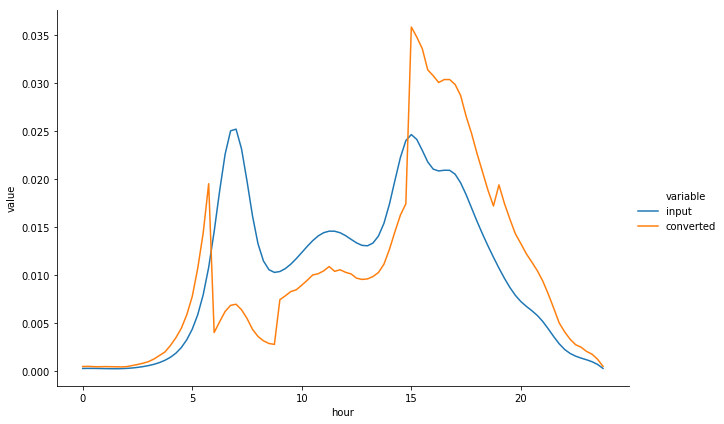

In [57]:
fig, ax = plt.subplots(figsize=(12,8))
g = sns.relplot(x="hour", y="value", hue='variable', kind="line", data=df_diurnals, aspect=1.5, height=6)

#### Period Totals

In [58]:
def period(r):
    if 0 <= r < 6 or 19 <= r < 24:
        return 'ov'
    elif 6 <= r < 9:
        return 'am'
    elif 9 <= r < 15:
        return 'md'
    else:
        return 'pm'

In [59]:
df_input_diurnal['period'] = df_input_diurnal.HOUR.apply(period)
df_input_diurnal_period_totals = df_input_diurnal.groupby('period', as_index=False)['SHARE'].sum()
df_input_diurnal_period_totals

,period,SHARE
0,am,0.211
1,md,0.348
2,ov,0.133
3,pm,0.307


In [64]:
# df_flat_trip['period'] = df_flat_trip.stime_hr.apply(period)
# df_converted_diurnal_period_totals = df_flat_trip.groupby('period', as_index=False)['vid'].count()
# df_converted_diurnal_period_totals.vid = df_converted_diurnal_period_totals.vid / np.sum(df_converted_diurnal_period_totals.vid)
# df_converted_diurnal_period_totals.rename({'vid':'SHARE'}, axis=1, inplace=True)
df_converted_diurnal_period_totals

,period,SHARE
0,am,0.058
1,md,0.254
2,ov,0.242
3,pm,0.446
